# CrabNet whole device stack test

Here I attempt to use CrabNet for PCE prediction. I transform the entire device stack into a formula to give to the net for prediction.

In [62]:
import pandas as pd
import pickle
import ast
import matplotlib.pyplot as plt
import requests
import numpy as np

In [63]:
# Build a dataframe that contains all predictors and only contains fully identified cells for a start
df = pd.read_csv('pickles/df_all_cells_many_properties.csv')

# eliminate all cells that have non-identified htls or etls. This pickle
# was created in How_many_cells_identified.ipynb
with open('pickles/df_all_ctls_identified_v2.pkl', 'rb') as f:
    df_id = pickle.load(f)

# add the both_identified column to df and only keep the fully identified cells
df['both_identified'] = df_id['both_identified']
df_all_identified = df[df['both_identified'] == True]

# NOTE: We also eliminated 31 cells that contain no etl and htl at all

In [64]:
# drop cells without a device stack information (306)
df_all_identified['device_stack'] = df_all_identified['device_stack'].apply(ast.literal_eval)
print(len(df_all_identified))
df_all_identified = df_all_identified.dropna(subset=['device_stack'])
print(len(df_all_identified))

# drop voc, jsc, ff, structural_dimensionality, and both_identified columns
df_all_identified = df_all_identified.drop(columns=['voc', 'jsc', 'ff', 'structural_dimensionality', 'both_identified'])



37633
37327


/tmp/ipykernel_99/1931154253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_identified['device_stack'] = df_all_identified['device_stack'].apply(ast.literal_eval)


In [65]:
# Change ";" lists into proper lists separated by commas
for index, _ in df_all_identified.iterrows():
    i = 0
    while i < len(df_all_identified.at[index, "device_stack"]):
        if ";" in df_all_identified.at[index, "device_stack"][i]:
            elements = df_all_identified.at[index, "device_stack"][i].split(";")
            df_all_identified.at[index, "device_stack"] = df_all_identified.at[index, "device_stack"][:i] + elements + df_all_identified.at[index, "device_stack"][i+1:]
        i += 1

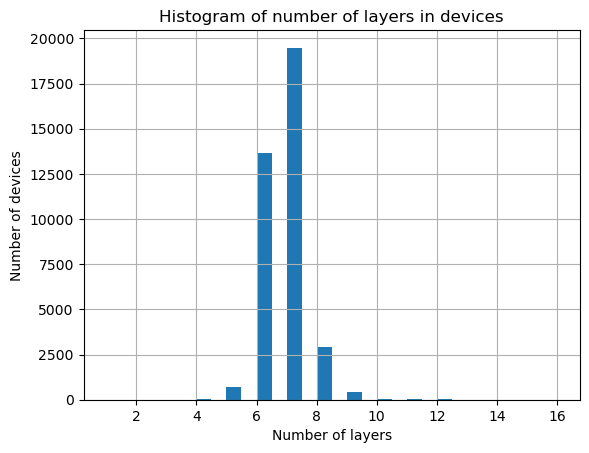

In [66]:
# plot the length of lists of all device stacks within df_all_identified
df_all_identified['device_stack'].apply(len).hist(bins=30)

# add axis titles
plt.xlabel('Number of layers')
plt.ylabel('Number of devices')
plt.title('Histogram of number of layers in devices')
plt.show()

In [67]:
# table of the frequency of the last layer
last_layer = df_all_identified['device_stack'].apply(lambda x: x[-1])
print(last_layer.value_counts().head(20))

Au            18348
Ag            11674
Al             3300
Carbon         1997
Cu              693
SLG             106
ITO              97
MoO3             72
FTO              68
Ag-nw            65
AgAl             65
PEDOT:PSS        50
Carbon-nt        46
PDMS             44
Perovskite       39
Graphite         33
MgF2             28
Carbon-mp        22
PET              21
IZO              20
Name: device_stack, dtype: int64


# Transforming the Device Stacks into Chemical formulas

Primarily, we need a dictionary of materials to chemical formulas.
We can use the already existing CTL dictionary and enhance it with electrode
materials. Therefore, we can recycle a lot of the original identification.

In [68]:
def search_pubchem_by_name(industry_name):
    '''
    This searches for a CTL material's CID in PubChem.
    Arguments:  industry_name (str) - the name of the material
                when_called (str) - "initial" or other; used to determine which 
                                    counter to increment
    Value: CID (int) - the CID of the material
    '''
    
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{industry_name}/cids/JSON"
    
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        data = data['IdentifierList']['CID'][0]
        return data
    else:
        # if search in PubChem compounds fails, search in substances
        url_subs = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/name/{industry_name}/cids/JSON"

        response = requests.get(url_subs)

        if response.status_code == 200:
            data = response.json()
            data = data['InformationList']['Information'][0]['CID'][0]
            print("Substance search SUCCESSFUL")
            return data
        else:
            # if the search failed again, report failure
            print('debug: substance search unsuccessful')
            raise Exception(f"Error: Could not retrieve SID using the industry name alone. Status code: {response.status_code}")


def name_to_cid(industry_name, df):
    '''
    This function searches for the PubChem CID for materials. It tries to find
    the chemical name behind materials' industry name, searches for their CID
    and adds them to a dictionary. 
    Arguments:
        industry_name (str) - the name of the material
        df (pandas.DataFrame) - a dataframe with columns etl, htl and ref, 
        containing etl and htl materials and the DOI links to their papers
    Value:
        No value is returned but the name_to_CID_dict is updated.
    '''
    # skip if CID is none
    if industry_name == "none":
        return
    # skip if CID is already in the dictionary
    elif industry_name in name_to_CID_dict.keys() and name_to_CID_dict[industry_name] is not None:
        print('debug: material already in dictionary')
        return
    else:
        CID = None
        # procedure that tries to find the CID
        try:
            CID = search_pubchem_by_name(industry_name)
            print('debug: initial search_pubchem_by_name SUCCESSFUL!')
            name_to_CID_dict[industry_name] = CID
            print('debug: CID added to dictionary')
            return            
        except:
            CID = None
            name_to_CID_dict[industry_name] = CID
            return

In [69]:
# Main Program of the Transformation
# build list of materials (takes a 7 minutes)
device_stack_materials = set(df_all_identified['device_stack'].sum())
len(device_stack_materials)

1101

In [ ]:
# load existing dictionary
#with open('pickles/dict_all_cells_v2.pkl', 'rb') as f:
#    name_to_CID_dict = pickle.load(f)

# check out more materials in pubchem (25 minutes)
for index, material in enumerate(device_stack_materials):
    print(f"Next up: {material}. Progress: {index/len(device_stack_materials)}")
    name_to_cid(material, df_all_identified)

In [73]:
len([x for x in name_to_CID_dict.values() if x is not None])
# The dictionary has 917 entries that are not none as opposed to 825 it had 
# with only the CTL materials.
# ~ 2800 entries, 917 of which not None

916

In [74]:
# Let's check if there are materials that appear much but are not identified
# For the materials that have value None in the dictionary, in how many of the
# rows do they appear?
counts = []
for key, value in name_to_CID_dict.items():
    if value is None:
        counts.append([key, df_all_identified['device_stack'].apply(lambda x: key in x).sum()])

df_counts = pd.DataFrame(counts, columns=['key', 'count'])

In [75]:
print(df_counts.sort_values(by='count', ascending=False))

# sum of all counts
print(df_counts['count'].sum())

# 1113 cells contain unidentified materials in their device stack. They should
# be eliminated for ML.

                  key  count
105               IZO     97
1832          bis‐C60     38
1849           A.R.C.     36
1839          Ag-grid     33
1935          Ti-foil     30
...               ...    ...
652          TPADPP-1      0
651         IDF-SFXPh      0
650        HOOC-Ph-SH      0
649   ZnO0.9Sn0.1O1.1      0
977             TEACl      0

[1955 rows x 2 columns]
1117


In [76]:
# drop rows where the device stack column contains materials that have a None entry in the dictionary
print(len(df_all_identified))
df_all_identified = df_all_identified[~df_all_identified['device_stack'].apply(lambda x: any([name_to_CID_dict[material] is None for material in x]))]
print(len(df_all_identified))

# 1036 rows were dropped. The discrepancy of 77 to the 1113 above means that in
# 77 device stacks, there was more than one unidentified material.

37327
36287


In [77]:
# The "Perovskite" part in the device stacks appears to also have been
# "identified", but this is a mistake, as Perovskite is a group of materials.
# However, it does not matter as the Perovskite will be processed differently
# from the other parts of the device stack in the following transformation.
name_to_CID_dict['Perovskite']

16212381

In [102]:
# for later use: pickle updated dictionary
with open('pickles/dict_device_stack_materials.pkl', 'wb') as f:
    pickle.dump(name_to_CID_dict, f)

In [46]:
# load updated dictionary
with open('pickles/dict_device_stack_materials.pkl', 'rb') as f:
    dict_ds_materials = pickle.load(f)

In [78]:
def CID_to_Chem(CID):
    '''
    This searches for a CTL material's CID in PubChem.
    Argument: industry_name (str) - the name of the material
    Value: CID (int) - the CID of the material
    '''
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{CID}/property/MolecularFormula/JSON"
    
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        data = data['PropertyTable']['Properties'][0]['MolecularFormula']
        return data
    else:
        print('debug: Formula could not be retrieved')
        raise Exception(f"Error: Could not retrieve Formula from this CID. Status code: {response.status_code}")
        return None

In [ ]:
# Get the chemical formula for each CID in the dictionary
name_to_mol_form_dict = {}

# populate the SMILES dictionary
for index, name in enumerate(dict_ds_materials):
    print(f"{index+1}/{len(dict_ds_materials)}. Next up: {name}")
    CID = dict_ds_materials[name]
    if CID is not None:
        print(CID)
        formula = CID_to_Chem(CID)
        name_to_mol_form_dict[name] = formula
    else:
        name_to_mol_form_dict[name] = None

In [81]:
# worked for all materials
len([x for x in dict_ds_materials.values() if x is not None])

917

In [113]:
with open('pickles/dict_ds_materials_to_chem.pkl', 'wb') as f:
    pickle.dump(name_to_mol_form_dict, f)

In [47]:
with open('pickles/dict_ds_materials_to_chem.pkl', 'rb') as f:
    name_to_mol_form_dict = pickle.load(f)

In [82]:
print(len(df_all_identified))
# drop rows from df_all_identified where the column reduced_formulas contains nan
df_all_identified = df_all_identified.dropna(subset=['reduced_formulas'])
print(len(df_all_identified))

36287
36287


In [ ]:
# Now we have the dictionary for the materials in the dataframe.
# Next up: construct a formula string for each device stack.
# ca. 30 seconds

combined_formulae = []

for index, row in df_all_identified.iterrows():
    formula_list = []
    for element in row['device_stack']:
        if element == "Perovskite":
            formula = row['reduced_formulas']
        else:
            formula = name_to_mol_form_dict[element]
        formula_list.append(formula)
    print(formula_list)
    combined_formula = "".join(formula_list)
    print(combined_formula)
    combined_formulae.append(combined_formula)
    

In [84]:
df_all_identified['device_stacks_chem'] = combined_formulae
df_all_identified

,reduced_formulas,iupac_formulas,descriptive_formulas,bandgap,pce,device_stack,htl,etl,device_stacks_chem
1,CH6I3NPb,PbCNH6I3,MAPbI3,None,14.1,"[SLG, ITO, PEDOT:PSS, Perovskite, PCBM-60, Bph...",['PEDOT:PSS'],"['PCBM-60', 'Bphen']",C39H72O5In2O5SnC14H14O5S2CH6I3NPbC72H14O2C24H1...
2,CH6I3NPb,PbCNH6I3,MAPbI3,2.4032649509999997e-19,5.5,"[SLG, FTO, TiO2-c, TiO2-mp, Perovskite, Au]",['none'],"['TiO2-c', 'TiO2-mp']",C39H72O5C39H52N4O6O2TiO2TiCH6I3NPbAu
3,CH6I3NPb,PbCNH6I3,MAPbI3,2.5634826144e-19,11.82,"[SLG, ITO, PEDOT:PSS, Perovskite, PCBM-60, Bph...",['PEDOT:PSS'],"['PCBM-60', 'Bphen']",C39H72O5In2O5SnC14H14O5S2CH6I3NPbC72H14O2C24H1...
5,CH6I3NPb,PbCNH6I3,MAPbI3,2.5634826144e-19,9.9,"[SLG, FTO, TiO2-c, Perovskite, Spiro-MeOTAD, Au]",['Spiro-MeOTAD'],['TiO2-c'],C39H72O5C39H52N4O6O2TiCH6I3NPbC81H68N4O8Au
6,CH6I3NPb,PbCNH6I3,MAPbI3,2.5634826144e-19,18.67,"[SLG, FTO, TiO2-c, Perovskite, Spiro-MeOTAD, Ag]",['Spiro-MeOTAD'],['TiO2-c'],C39H72O5C39H52N4O6O2TiCH6I3NPbC81H68N4O8Ag
...,...,...,...,...,...,...,...,...,...
43103,CH6I3NPb,PbCNH6I3,MAPbI3,2.5634826144e-19,7.0,"[SLG, FTO, TiO2-c, TiO2-mp, Perovskite, Spiro-...",['Spiro-MeOTAD'],"['TiO2-c', 'TiO2-mp']",C39H72O5C39H52N4O6O2TiO2TiCH6I3NPbC81H68N4O8Ag
43104,CH6I3NPb,PbCNH6I3,MAPbI3,2.5634826144e-19,11.9,"[SLG, FTO, ZnO-c, ZnO-nw, Perovskite, Spiro-Me...",['Spiro-MeOTAD'],"['ZnO-c', 'ZnO-nw']",C39H72O5C39H52N4O6OZnOZnCH6I3NPbC81H68N4O8Au
43105,CH6I3NPb,PbCNH6I3,MAPbI3,2.5634826144e-19,11.8,"[SLG, ITO, PEDOT:PSS, Perovskite, PCBM-60, BCP...",['PEDOT:PSS'],"['PCBM-60', 'BCP']",C39H72O5In2O5SnC14H14O5S2CH6I3NPbC72H14O2C26H2...
43106,CH6I3NPb,PbCNH6I3,MAPbI3,2.5634826144e-19,16.43,"[SLG, FTO, SnO2-c, Perovskite, Spiro-MeOTAD, Au]",['Spiro-MeOTAD'],['SnO2-c'],C39H72O5C39H52N4O6O2SnCH6I3NPbC81H68N4O8Au


# CrabNet for Device Stacks

Now we can use CrabNet to predict PCE using the device stacks as predictors.

In [85]:
# drop None values from pce column
df_cn = df_all_identified.dropna(subset=['pce'])  # Drop rows with NaN values in the "pce" column
df_cn = df_cn[df_cn['pce'] != 'None']  # Drop rows with 'None' values in the "pce" column
df_cn['pce'] = df_cn['pce'].astype(float)  # Convert "pce" column to float data type
#df_grouped = df_grouped.groupby(['reduced_formulas', 'device_stack'])['pce'].mean().reset_index()  # Group by "reduced_formulas" and "device_stack", and take the mean of "pce" values
#df_cn = df_cn.drop(["iupac_formulas", "descriptive_formulas", "bandgap"], axis=1)
# why group by the predictors and average pce within the groups?
# I don't see the reason behind step 4 and therefore skip it

In [86]:
df_cn.rename(columns={'pce': 'target'}, inplace=True)
df_cn.rename(columns={'device_stacks_chem': 'formula'}, inplace=True)


In [87]:
df_cn = df_cn[~df_cn['formula'].str.contains("\+")]
print(len(df_cn))
df_cn = df_cn[~df_cn['formula'].str.contains("\-")]
print(len(df_cn))

35446
35433


In [88]:
# randomize the dataframe and split into train_df, val_df and test_df in the ratio of 0.8, 0.1, 0.1
train_df, val_df, test_df = \
              np.split(df_cn.sample(frac=1, random_state=42), 
                       [int(.8*len(df_cn)), int(.9*len(df_cn))])

In [96]:
type(train_df['formula'].loc[1])

str


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Generating EDM:  49%|████▉     | 13858/28346 [00:00<00:00, 69328.44formulae/s]

skipping composition OrderedDict([('C', 176.0), ('H', 158.0), ('O', 14.0), ('N', 6.0), ('Ni', 1.0), ('None', 1.0), ('Ag', 1.0)])
skipping composition OrderedDict([('C', 157.0), ('H', 131.0), ('O', 20.0), ('In', 2.0), ('S', 2.0), ('N', 2.0), ('Sn', 1.0), ('None', 1.0), ('Cl', 1.0), ('F', 1.0), ('Li', 1.0), ('Ag', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 21.0), ('N', 8.0), ('Sn', 1.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([

Generating EDM: 100%|██████████| 28346/28346 [00:00<00:00, 68079.82formulae/s]

skipping composition OrderedDict([('H', 140.0), ('C', 120.0), ('O', 20.0), ('N', 4.0), ('In', 2.0), ('Sn', 2.0), ('None', 2.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 21.0), ('N', 8.0), ('Ti', 1.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('C', 139.0), ('H', 106.0), ('O', 13.0), ('N', 3.0), ('In', 2.0), ('Sn', 1.0), ('P', 1.0), ('None', 1.0), ('Cu', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 140.0), ('C', 120.0), ('O', 20.0), ('N', 4.0), ('In', 2.0), ('Sn', 1.0), ('Ti', 1.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict(

loading data with up to 16 elements in the formula
training with batchsize 2048 (2**11.000)


Generating EDM:   0%|          | 0/3543 [00:00<?, ?formulae/s]

skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 124.0), ('C', 79.0), ('O', 15.0), ('N', 4.0), ('Ti', 2.0), ('None', 1.0)])
skipping composition OrderedDict([('C', 146.0), ('H', 113.0), ('O', 10.0), ('N', 3.0), ('In', 2.0), ('Sn', 1.0), ('None', 1.0), ('Cu', 1.0)])
skipping composition OrderedDict([('H', 140.0), ('C', 88.0), ('O', 15.0), ('N', 4.0), ('Ti', 2.0), ('None', 1.0), ('S', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 140.0), ('C', 120.0), ('O', 21.0), ('N', 4.0), ('In', 2.0), ('Sn', 1.0), ('Ti', 1.0), ('None', 1.0), ('Mo', 1.0), ('Al', 1.0)])
skipping composition OrderedDict([('H', 124.0), 

Generating EDM: 100%|██████████| 3543/3543 [00:00<00:00, 69710.28formulae/s]


skipping composition OrderedDict([('H', 140.0), ('C', 120.0), ('O', 20.0), ('N', 4.0), ('In', 2.0), ('Sn', 2.0), ('None', 2.0), ('Au', 1.0)])
loading data with up to 14 elements in the formula
stepping every 140 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 4.33 val mae: 4.34


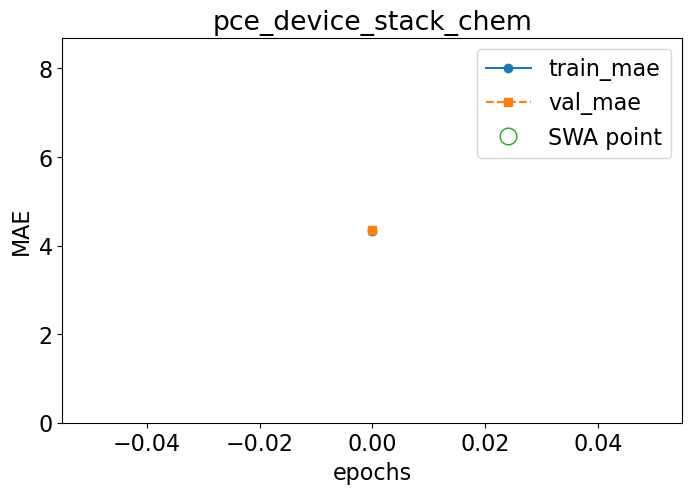

Epoch: 19/300 --- train mae: 3.02 val mae: 3.05


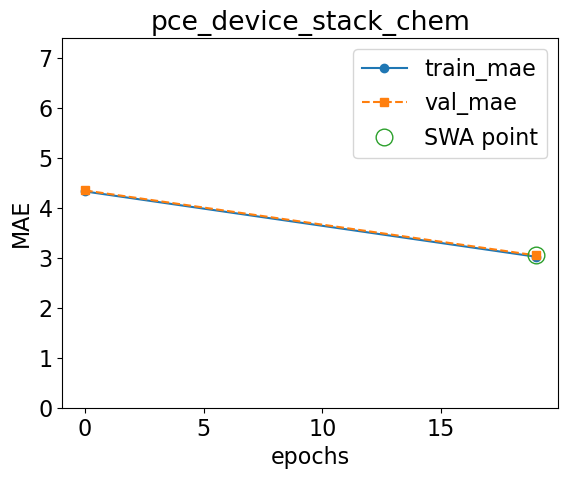

Epoch: 39/300 --- train mae: 2.72 val mae: 2.86


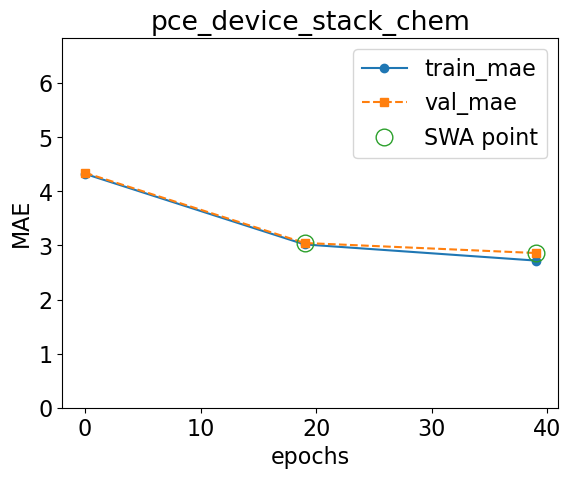

Epoch: 59/300 --- train mae: 2.58 val mae: 2.81


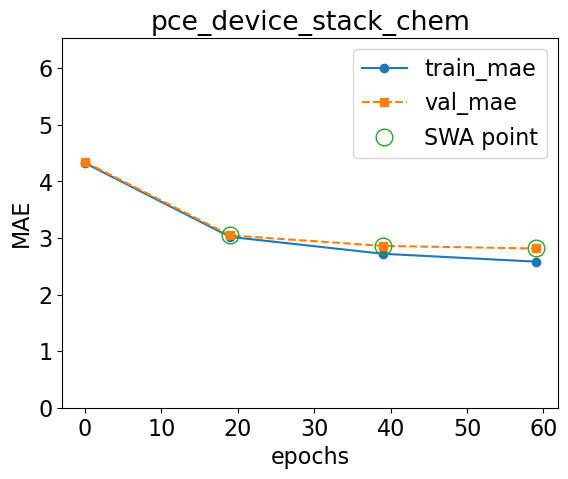

Epoch: 79/300 --- train mae: 2.51 val mae: 2.79


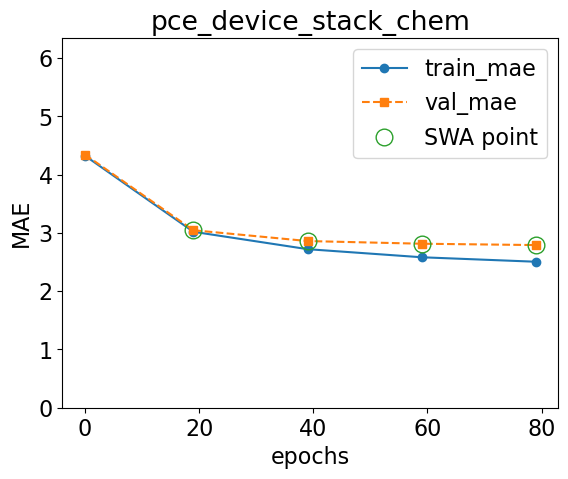

Epoch: 99/300 --- train mae: 2.45 val mae: 2.77


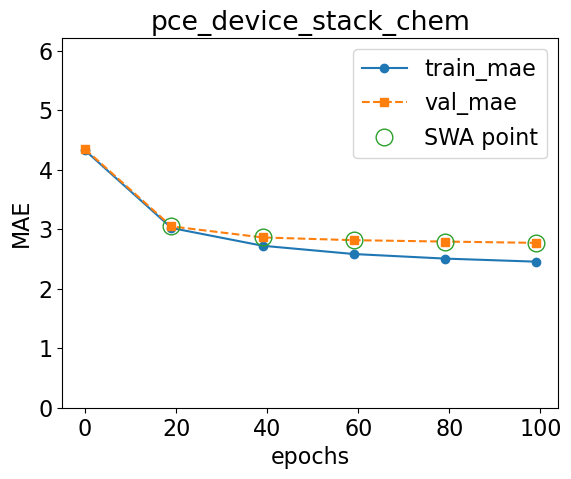

Epoch: 119/300 --- train mae: 2.42 val mae: 2.76


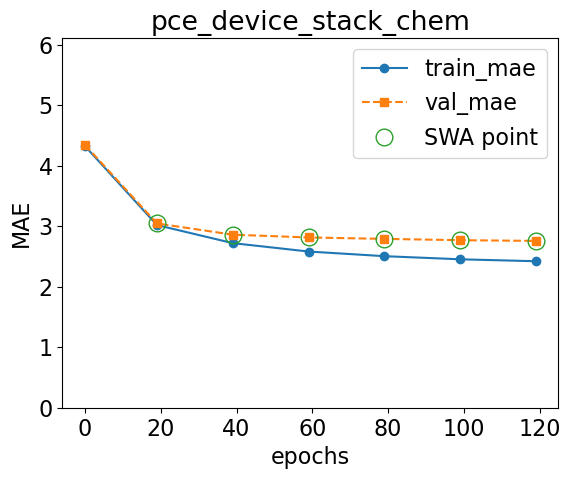

Epoch: 139/300 --- train mae: 2.4 val mae: 2.74


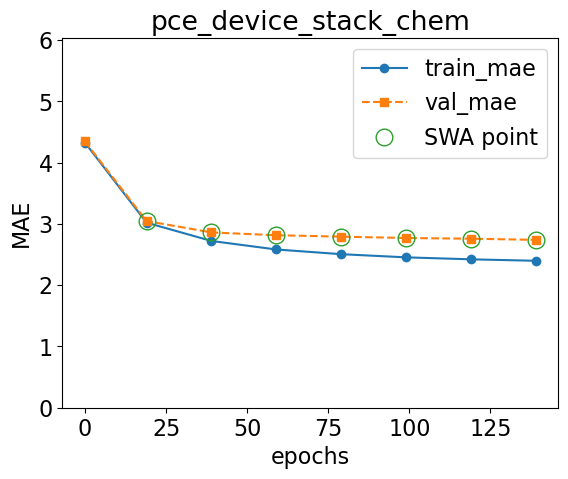

Epoch: 159/300 --- train mae: 2.38 val mae: 2.74


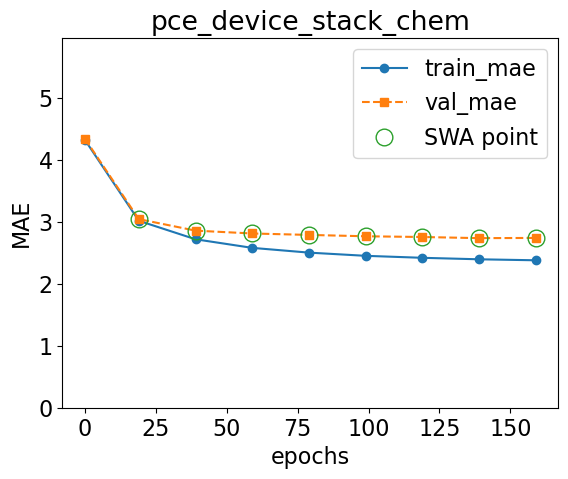

Epoch: 179/300 --- train mae: 2.37 val mae: 2.73


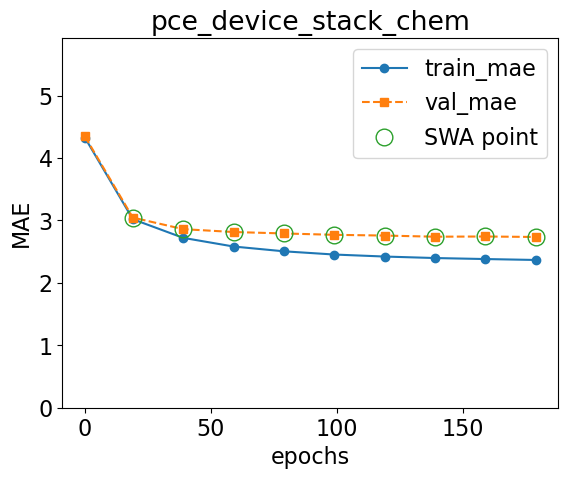

Epoch: 199/300 --- train mae: 2.36 val mae: 2.72


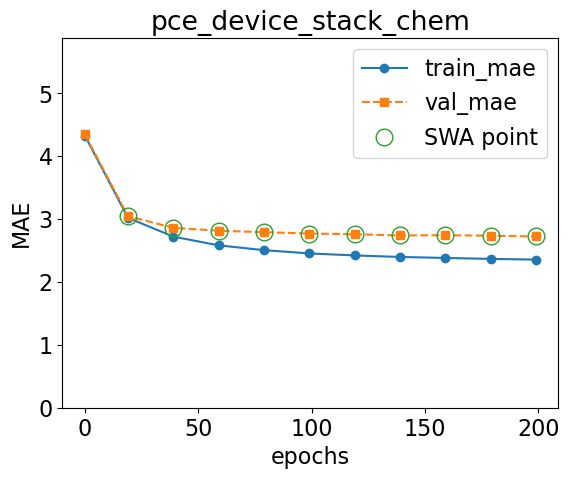

Epoch: 219/300 --- train mae: 2.35 val mae: 2.72


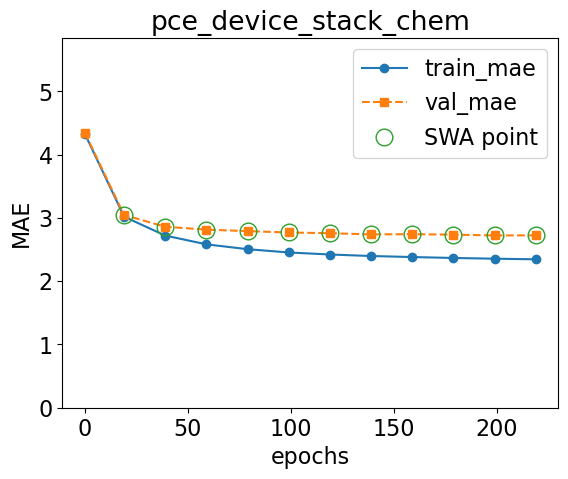

Epoch: 239/300 --- train mae: 2.34 val mae: 2.72


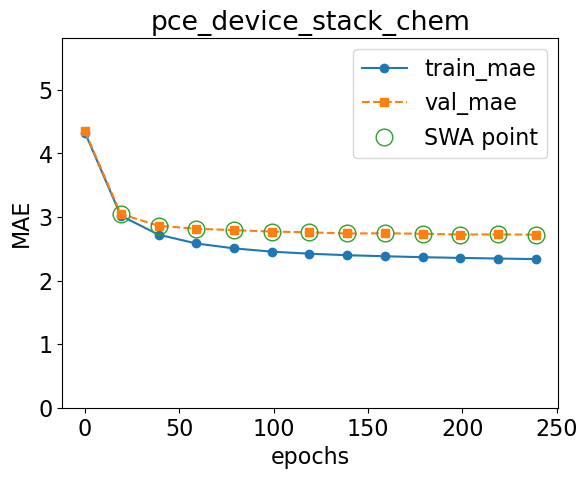

Epoch: 259/300 --- train mae: 2.33 val mae: 2.71


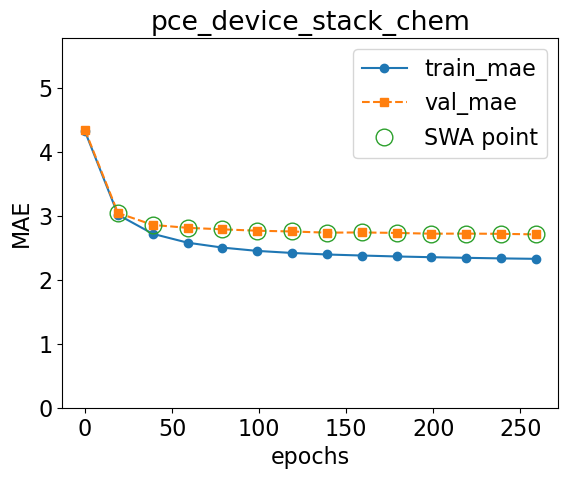

Epoch: 279/300 --- train mae: 2.32 val mae: 2.71


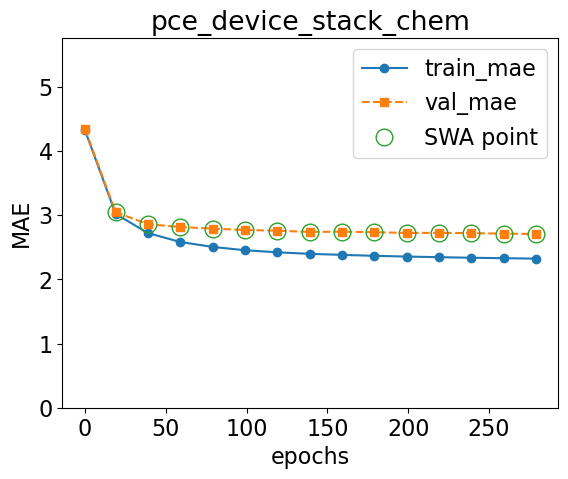

Epoch: 299/300 --- train mae: 2.32 val mae: 2.7


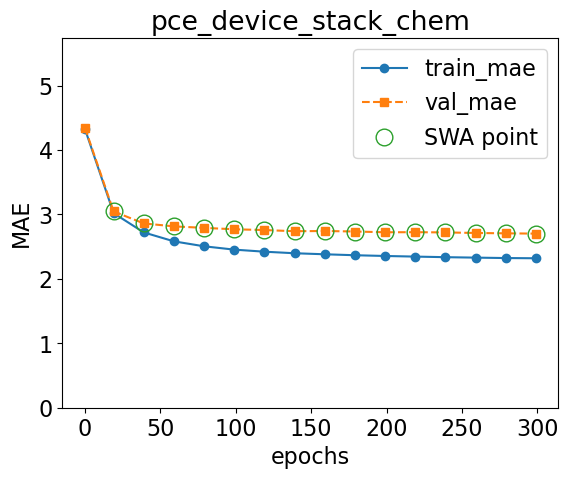

Saving network (pce_device_stack_chem) to models/trained_models/pce_device_stack_chem.pth


In [97]:
# cb = CrabNet(
#     mat_prop="pce",
#     train_df=train_df, # contains "formula", "target", and "state_var0" columns
#     extend_features=['device_stack_encoded', 'etl_encoded', 'htl_encoded'],
#     )
from crabnet.crabnet_ import CrabNet
#cb_pce = CrabNet(mat_prop="pce", model_name='pce_device_stack_chem', elem_prop='mat2vec', learningcurve=False, extend_features=['bandgap'])
cb_pce = CrabNet(mat_prop="pce", model_name='pce_device_stack_chem', elem_prop='mat2vec', learningcurve=False)
cb_pce.fit(train_df, val_df)

In [98]:
import pickle
with open('pickles/device_stack_chem_formula_model.pkl', 'wb') as f:
    pickle.dump(cb_pce, f)

In [100]:
from crabnet.utils.figures import act_pred
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Generating EDM:  50%|████▉     | 14152/28346 [00:00<00:00, 70831.78formulae/s]

skipping composition OrderedDict([('C', 176.0), ('H', 158.0), ('O', 14.0), ('N', 6.0), ('Ni', 1.0), ('None', 1.0), ('Ag', 1.0)])
skipping composition OrderedDict([('C', 157.0), ('H', 131.0), ('O', 20.0), ('In', 2.0), ('S', 2.0), ('N', 2.0), ('Sn', 1.0), ('None', 1.0), ('Cl', 1.0), ('F', 1.0), ('Li', 1.0), ('Ag', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 21.0), ('N', 8.0), ('Sn', 1.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([

Generating EDM: 100%|██████████| 28346/28346 [00:00<00:00, 70029.54formulae/s]

skipping composition OrderedDict([('C', 219.0), ('H', 192.0), ('O', 21.0), ('N', 8.0), ('Ti', 1.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 140.0), ('C', 120.0), ('O', 20.0), ('N', 4.0), ('In', 2.0), ('Sn', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('C', 125.0), ('H', 100.0), ('O', 17.0), ('In', 2.0), ('S', 2.0), ('Sn', 1.0), ('None', 1.0), ('Al', 1.0)])
skipping composition OrderedDict([('H', 140.0), ('C', 120.0), ('O', 20.0), ('N', 4.0), ('In', 2.0), ('Sn', 2.0), ('None', 2.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 21.0), ('N', 8.0), ('Ti', 1.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.

loading data with up to 14 elements in the formula


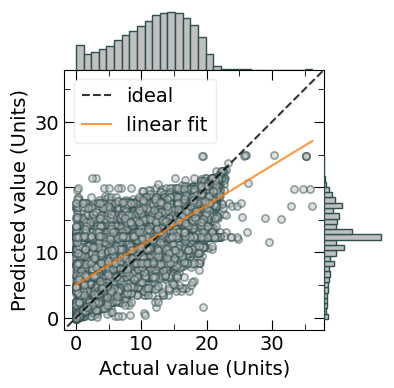

R2 score: 0.5702678252232174
MSE: 11.852650617117703
MAE: 2.319963130681725 %


In [101]:
# Training accuracy
# replcae with zeros to predict the target value
train_df_zeros = pd.DataFrame(({
    "formula": train_df['formula'],
    "target": [0.0]*len(train_df['formula']),
    "device_stack": train_df['device_stack']}))
train_df_predicted, train_df_predicted_sigma = cb_pce.predict(train_df_zeros, return_uncertainty=True)

act_pred(train_df['target'], train_df_predicted)
r2 = r2_score(train_df['target'], train_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(train_df['target'], train_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(train_df['target'], train_df_predicted)
print(f'MAE: {mae} %')

Generating EDM: 100%|██████████| 3543/3543 [00:00<00:00, 81735.98formulae/s]


skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 124.0), ('C', 79.0), ('O', 15.0), ('N', 4.0), ('Ti', 2.0), ('None', 1.0)])
skipping composition OrderedDict([('C', 146.0), ('H', 113.0), ('O', 10.0), ('N', 3.0), ('In', 2.0), ('Sn', 1.0), ('None', 1.0), ('Cu', 1.0)])
skipping composition OrderedDict([('H', 140.0), ('C', 88.0), ('O', 15.0), ('N', 4.0), ('Ti', 2.0), ('None', 1.0), ('S', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 192.0), ('C', 159.0), ('O', 23.0), ('N', 8.0), ('Ti', 2.0), ('None', 1.0), ('Au', 1.0)])
skipping composition OrderedDict([('H', 140.0), ('C', 120.0), ('O', 21.0), ('N', 4.0), ('In', 2.0), ('Sn', 1.0), ('Ti', 1.0), ('None', 1.0), ('Mo', 1.0), ('Al', 1.0)])
skipping composition OrderedDict([('H', 124.0), 

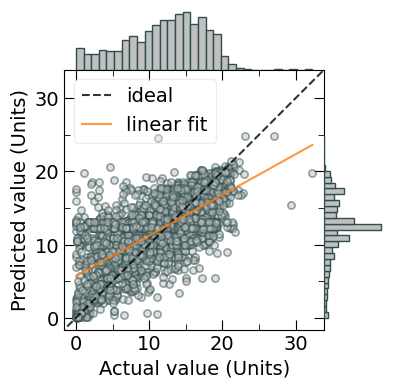

R2 score: 0.49626172871299945
MSE: 13.98325712920514
MAE: 2.702266943884281 %


In [102]:
# Validation accuracy
# replcae with zeros to predict the target value
val_df_zeros = pd.DataFrame(({
    "formula": val_df['formula'],
    "target": [0.0]*len(val_df['formula']),
    "device_stack": val_df['device_stack']}))
val_df_predicted, val_df_predicted_sigma = cb_pce.predict(val_df_zeros, return_uncertainty=True)

act_pred(val_df['target'], val_df_predicted)
r2 = r2_score(val_df['target'], val_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(val_df['target'], val_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(val_df['target'], val_df_predicted)
print(f'MAE: {mae} %')